# Apple Stock Price Prediction - Modelling

## Capstone Project Two : Springboard Data Science career track
**Notebook by Md Saimoom Ferdous**

### Problem Statement

Apple Inc. is one of american the big tech multinational technology companies, headquartered in California, that is known for the fine design, development and selling of consumer electronics, computer softwares and online services. It is one of the top 10 Fortune 500 companies and ranks top in the Nasdaq stock exchange. Its stock price is closely watched by millions of people around the world. Short medium and long term stock prediction is of interest for investors, companies to plan their financial strategy well ahead of time. During the economic downturn stock market prediction becomes even more complex. Given the long historic data that captures rare economic downturn events can provide insight for better prediction coupled with relevant features (dividend, earning). This project will aim in that pursuit.


### The Data

- Data will be sourced from a Kaggle platform, consisting of historical data (1998-2020) of 700+ companies coming from: Nasdaq, Yahoo finance, Zacks, Alpha vintage (https://www.kaggle.com/tsaustin/us-historical-stock-prices-with-earnings-data?).
- Data wrangling, EDA and pre-processing will be done to get time-series closing price of Apple's stock


### Question(s) of Interest

EDA will look to answer following questions:

- Which day of the week, week of the month, month of the year, quarter of the year see minimum, maximum stock price
- Which month, quarter of the eyar see the biggest gain (price chnages)
- Which time of the year sees most earning per share 
- How the dividend is coming up over the past years
- Can we see noticable stock price change during economic recession in 2008
- How the other stock variabes such as volume, eps, dividend are correlated with the price variable

The modelling stage will focus on: 

- Answering, can we come up with a better model that can capture sudden economic downturs along with seasonal variation for improved predictability of Apple's stock price


### 1. Data Wrangling

This step consists of multiple components including Data Collection, Data Organization, Data Definitions, and Data Cleaning.
- Data consisted of four CSV files (dividend, earning, stock price data and summary). Apple data were filtered out from other companies and saved dividend, earning, stock price data in a sigle CSV file for EDA step
- Details have been described in this notebook: https://github.com/saimoom026/Springboard/blob/student-branch/springboard/Capstone%20two/Stock-price-prediction-data-wrangling.ipynb


### 2. Exploratory Data Analysis

Conducted EDA on Apple historical stock data to examine relationships between variables and other patterns in the data.
- Seasonal stock price variation (weekdays, week of the month, month, quarter)
- Price change (monthly, quarterly)
- Anomalies and outliers
- Finding correlated variables
- Feature removals and save cleaned data for data preprocessing step
- Details can be found in the notebook: https://github.com/saimoom026/Springboard/blob/student-branch/springboard/Capstone%20two/Stock-price-prediction-EDA.ipynb


### 3. Data Pre-processing

This step consists of identifying predictor, feature variables and prepare the data redy for modelling stage, that includes testing for stationarity for time series modelling and converting into stationarity (if required) and then spliting the data into training and test set.

- Trend and seasonality decomposition of the stock price
- Stationarity check
- Transform data for stationarity
- Train-test split for modelling stage
- Details can be found here: https://github.com/saimoom026/Springboard/blob/student-branch/springboard/Capstone%20two/Stock-price-prediction-preprocess.ipynb


### 4. Modelling

This step consists of the following steps:
- Training and grid search optimizing popular ARIMA model and evaluate performances on the test data
- Training and tuning parameters for FBProphet model and evaluate performances on the test data
- Compare results between ARIMA and FBProphet models


## Load Relevant Libraries

In [565]:
# import basic libraries

import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

# to ignore warning message

import warnings
warnings.filterwarnings('ignore')


# import time series prediction model and relevant libraries 

from statsmodels.tsa.arima_model import ARIMA
#!pip install pmdarima
from pmdarima.arima import auto_arima
#!pip install fbprophet
from fbprophet import Prophet

from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

## Load the Data
Load Apple's stock data saved after Pre-processing step in step 3

In [566]:
train_data = pd.read_csv('data/apple_train_data.csv')
test_data = pd.read_csv('data/apple_test_data.csv')

In [567]:
train_data.head(5)

,date,close
0,1998-01-02,16.25
1,1998-01-05,15.88
2,1998-01-06,18.94
3,1998-01-07,17.50
4,1998-01-08,18.19


## Set Index with Date Column

In [568]:
# Set the index of the dataset with date column

train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

# Convert index to datetime data type

train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)
train_data.head(5)

,close
date,
1998-01-02,16.25
1998-01-05,15.88
1998-01-06,18.94
1998-01-07,17.50
1998-01-08,18.19


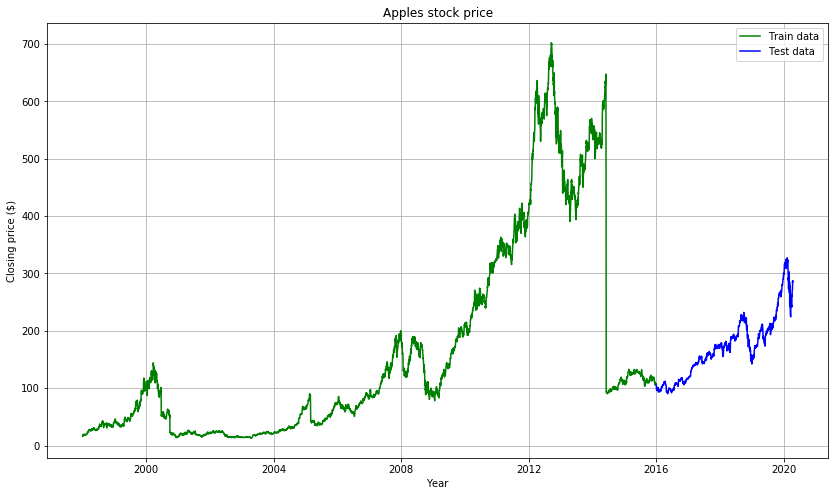

In [569]:
# plot the training and testing data

plt.figure(figsize=(14,8))
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Closing price ($)')
plt.plot(train_data.close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('Apples stock price')
plt.legend()
plt.show()

## Forecasting with ARIMA Modelling

ARIMA model will be used which is one of the most commonly used model for forecasting Apples stock price and stands for Auto Regressive Integrated Moving Average. General ARIMA model can be expressed as:

**predicted Y(t) = constant + linear combination lags of Y(t) (p lags) + linear combination lags of error in prediction terms (q lags)**

For example, Y(t) = 5 + 3 Y(t-1) + 2 $\phi$(t-1). 

Here, p=q=1. d stands for difeerencing needed for Y(t) to make the stationary.

There are many ways to determine best possible combinations of p, d and q values for a ARIMA model given a time seris data. One way would be manually plotiing auto correlation function (ACF) and partial autocorrelation function (PACF) for combinations of p, d and q parameters and determine the case for near zero ACF and PACF values. Here we will use auto_arima function that will output best optimized model parameters for ranges of p, q values based on Akaike information criterion (AIC). AIC is an estimator which assess the statistical quality of a model. Model with a lower AIC value results in the best fit with the training data with least features. 

The auto_arima function can do the grid search over p, d, q (related to ARIMA model) and P, D and Q (related to seasonal components) parameters and report back the model with best AIC value. 


### Finding Best Model Parameters 

In [570]:
# fit auto_arima model

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, # minimum p, q values
                      test='adf',                              # uses ADF test to determine differencing order 'd'
                                                               # needed for statioraity
                      max_p=3, max_q=3,                        # maximum p and q values
                      m=7,                                    # frequency of series, m=7 for daily observation
                      d=1,                                     # one step differencing, d=1 can make the data stationary
                                                               # seen from pre-processing step
                      seasonal=True,                           # observed seasonality
                      start_P=0,                               
                      D=0,                                     # auto_arima will come back with optimal P, Q and D parameters
                                                               # when 'seasonal' parameter is turned on
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)                           # step vs parallel. step is recommended for quicker performance


Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,1,7) [intercept=True]; AIC=46913.428, BIC=46933.900, Time=4.824 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=46912.275, BIC=46925.923, Time=0.761 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=46915.414, BIC=46942.711, Time=6.344 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=46915.416, BIC=46942.712, Time=11.462 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=46910.295, BIC=46917.119, Time=0.624 seconds
Fit ARIMA(0,1,0)x(1,0,0,7) [intercept=True]; AIC=46913.426, BIC=46933.899, Time=5.173 seconds
Fit ARIMA(0,1,0)x(1,0,1,7) [intercept=True]; AIC=46915.433, BIC=46942.729, Time=6.952 seconds
Fit ARIMA(1,1,0)x(0,0,0,7) [intercept=True]; AIC=46914.263, BIC=46934.735, Time=1.753 seconds
Fit ARIMA(0,1,1)x(0,0,0,7) [intercept=True]; AIC=46914.262, BIC=46934.735, Time=3.112 seconds
Fit ARIMA(1,1,1)x(0,0,0,7) [intercept=True]; AIC=46916.262, BIC=46943.559, Time=5.102 seconds
Total fit time:

In [571]:
# Lets see the summary findings of the modelling for best AIC values

model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6797
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -23454.147
Date:                Thu, 09 Jul 2020   AIC                          46910.295
Time:                        20:17:21   BIC                          46917.119
Sample:                             0   HQIC                         46912.650
                               - 6797                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        58.2337      0.022   2615.461      0.000      58.190      58.277
===================================================================================
Ljung-Box (Q):                       14.89   Jarque-Bera (JB):        4590319836.34
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              27.23   Skew:                           -55.76
Prob(H) (two-sided):                  0.00   Kurtosis:                      4027.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Observations:
- Best ARIMA model order was found to be (p, d, q) = (0,1,0), with AIC = 46910

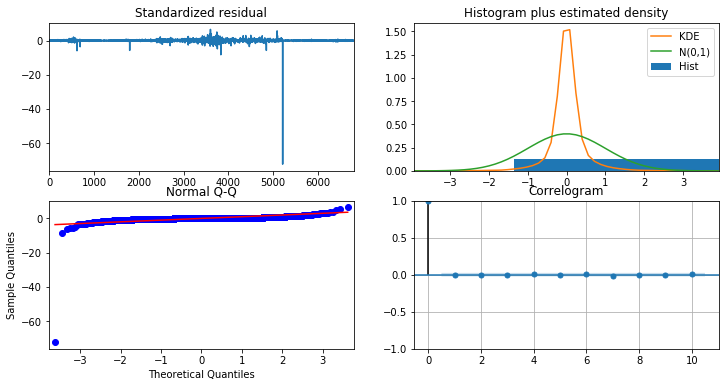

In [572]:
# Lets review the residual statistics from auto ARIMA model
# residuals should be closer to noise like statistics, which confirms not containing any information from the data

model_autoARIMA.plot_diagnostics(figsize=(12,6))
plt.grid(True)
plt.show()

Observations:
- **Top left**: residual values seem to fluctuate around zero values and uniform variance except at the tail end. This is coming from the steep downing fo the price after stock split in 2014
- **Top right**: The density plot suggests resembleness of residual distribution (orange color) with normal distribution (green one), with a mean zero
- **Bottom left**: The blue dots shouls perfectly align with the red line for a ideal scenario. This is the best possible alignment with the data
- **Bottom right**: The ACF of residuals are not correlated from the plot. Any correlation would suggest there are residual pattern in the data which is not not explained in the model and needs parameter adjustment
- Overall, it appears to be a good model and ready to use for forecasting
    

### Build Model with Best Model Parameters

In [573]:
# Lets build the ARIMA model with best p, d, q parameters

model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 6796
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -23454.137
Method:                           css   S.D. of innovations              7.631
Date:                Thu, 09 Jul 2020   AIC                          46912.275
Time:                        20:17:25   BIC                          46925.923
Sample:                             1   HQIC                         46916.985
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0131      0.093      0.141      0.887      -0.168       0.195


### Forecast with ARIMA Model
Now take the model to predict the stock price and compare with the test data set

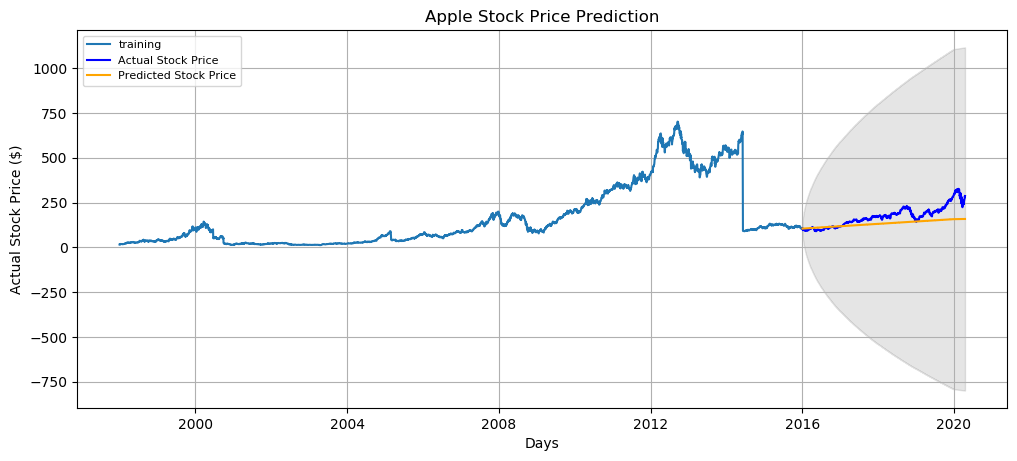

In [574]:
# Forecast

# generate forecast price data

fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)               # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)


# plot the train, test and forecast data

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Observations:
- The predicted stock price (in orange) seemed to follow the test data (blue) well initially. After that it devated from the observed test data
- The shaded grey region is the 95% confidence interval. Over time the confidence interval widens up, meaning the model looses its capability to confidently predict price over time


### Look Closely into the Predicted Price
Here, prediction will be plotted only for 2016-2020 for better observations

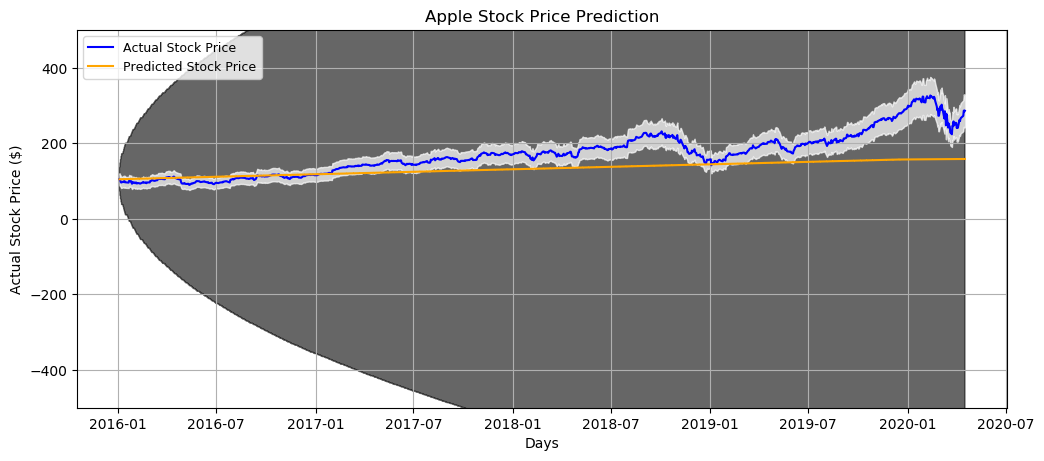

In [575]:
# plot only the train, test and forecast data for 2016-2020

plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series.values, upper_series.values, 
                 color='k', alpha=.60)
plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.ylim((-500,500))
plt.legend(loc='upper left', fontsize=9)


# mark the 15% price range around the test price data 

test_data_flat = test_data.close.ravel()  # converting dataframe to series

plt.fill_between(lower_series.index,.85*test_data_flat,1.15*test_data_flat,
                 color='white', alpha=.70)

plt.show()

Observations:
- The predicted price (orange) falls within the 15% price variation (white shaded region) over the 2016-2017
- Beyond 2017, predictions are in close proximity with observed price and foolow the trend but outside of 15% margin
- This suggests the built model can predict price well for a year  
- Prediction line seems like a linear line, not following the randomness patterns of the stock price data

### Performance Measure
Commonly used accuracy measures for time-series forecasting models are mean squared error, mean absolute error, root mean squared error, mean absolute percentage error. We will  be using these metrics on the forecast and test data to measure model performances.

In [576]:
# performance measures for the ARIMA model

mse = mean_squared_error(test_data_flat, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_flat, fc)
print('MAE: '+str(mae))

# root mean squared error
rmse = math.sqrt(mean_squared_error(test_data_flat, fc))
print('RMSE: '+str(rmse))

# mean absolute percentage error
mape = np.mean(np.abs(fc - test_data_flat/np.abs(test_data_flat)))
print('MAPE: '+str(mape))

# take the average score 

average = np.mean((mse, mae, rmse, mape))

# save the model performances as dataframe

ARIMA = pd.DataFrame({'model': 'ARIMA', 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'mape': [mape], 'average_score':[average]})
ARIMA.head()

MSE: 2288.3942816089525
MAE: 36.92786536166564
RMSE: 47.83716423042813
MAPE: 131.09659358446376


,model,mse,mae,rmse,mape,average_score
0,ARIMA,2288.394282,36.927865,47.837164,131.096594,626.063976


- Lower the metrics better the model would be
- We will compare this performance result with FBProphet model later part of the project

## Modelling with FBProphet
Classic forecasting models such as ARIMA needs lots of parameter tuning and expert knowledge in statistics and analytics. Facebook developed a open source library called FBProphet, which requires very little domain knowlegde, easy to integrate in automated production environment. BBProphet decomposes any time series data into trend, seasonality, event or holidays components and can be written as:

Y(t) = T(t) + S(t) + H(t) + $\epsilon$

T(t): piecewise linear or logistic growth curve for modelling trend components
S(t): cyclic changes in the time-series (dily/weekly/monthly/quarterly)
H(t): effect of holidays or unscheduled events
$\epsilon$: noisy term that can not be modelled with equation

As opposed to time based dependance, FBProphet considers forecasting as curve fitting problem. 

In this section, FBProphet will be used to model Apple stock price prediction. Modelling will start with a base model, then adding main three aspects of FBProphet, saturating growth, trend change and holiday effect.



### Data Re-arranging
FBProphet takes a dataframe with column names 'ds' and 'y' consisting of date and value of the time series

In [577]:
# rearrange data to suit Prophet model

# rename columns from date and cloe to ds and y
train_data.reset_index(inplace=True)
train_data.rename(columns={"date": "ds", "close": "y"},inplace=True)
train_data.tail(5)

,ds,y
6792,2015-12-30,107.32
6793,2015-12-31,105.26
6794,2015-12-31,105.26
6795,2015-12-31,105.26
6796,2015-12-31,105.26


### Base Model
Lets build first FBProphet model with Apple stock price data with 95% confidence level

#### Modelling 

In [611]:
# Build the model


m1=Prophet(interval_width=0.95)   # interval_width = confidence interval
m1.fit(train_data)

# number of days to forecast, based on test_data

test_data_unique = test_data.drop_duplicates(keep = 'first')     # removing duplicates if exists
forecast_days = 4 + (test_data_unique.index[-1]-test_data_unique.index[0]).days

# Create dataframe with the dates we want to predict

future = m1.make_future_dataframe(periods = forecast_days, freq = 'D')

# remove weekends from the prediction days

future_no_weekends = future[future['ds'].dt.dayofweek < 5]

# Predict the price

forecast = m1.predict(future_no_weekends)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecast

<Figure size 1200x500 with 0 Axes>

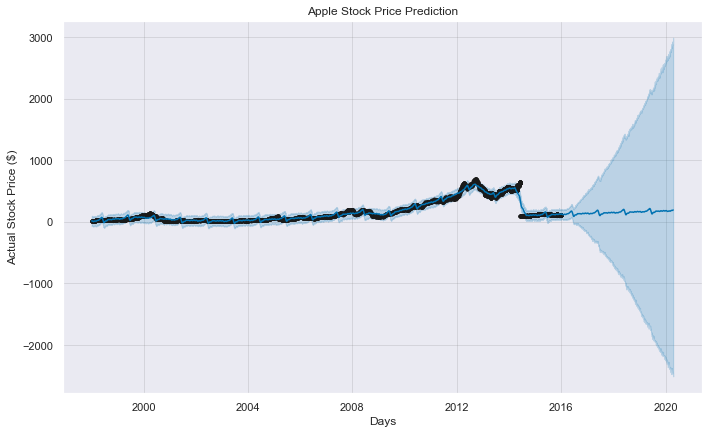

In [612]:
# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m1.plot(forecast)

plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.show()

#### Look Closely on the Test Data

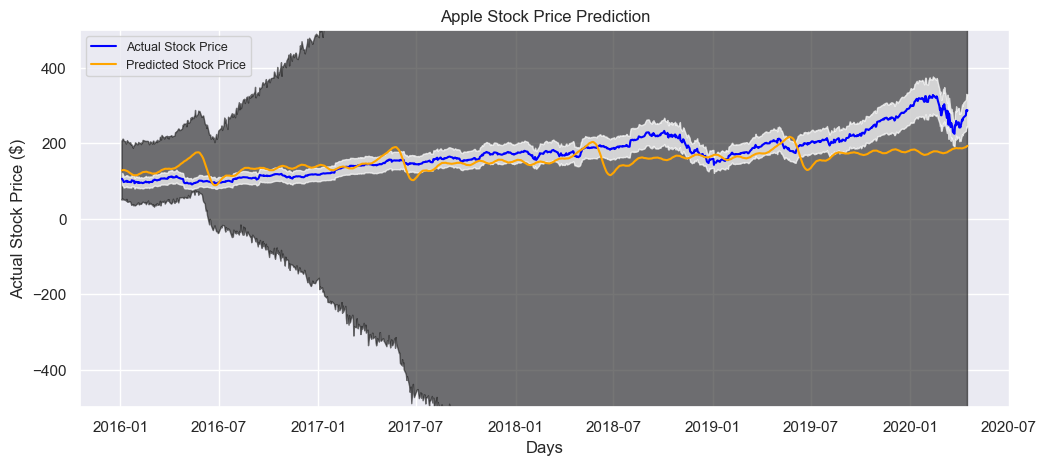

In [613]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_test = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data

plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_test.ds,fc_test.yhat, color = 'orange',label='Predicted Stock Price')

plt.fill_between(fc_test.ds, fc_test.yhat_lower.values, fc_test.yhat_upper.values, 
                 color='k', alpha=.60)
plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.ylim((-500,500))
plt.legend(loc='upper left', fontsize=9)


# mark the 15% price range around the test price data 

plt.fill_between(lower_series.index,.85*test_data_flat,1.15*test_data_flat,
                 color='white', alpha=.70)

plt.show()

- The predicted price (orange) added randomness and following well with the randomness of test data

#### Model Performance Evaluation

In [616]:
# performance measures for the simple FBProphet model

mse = mean_squared_error(test_data_unique, fc_test.yhat)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_unique, fc_test.yhat)
print('MAE: '+str(mae))

# root mean squared error
rmse = math.sqrt(mean_squared_error(test_data_unique, fc_test.yhat))
print('RMSE: '+str(rmse))

# mean absolute percentage error
mape = np.mean(np.abs(fc_test.yhat - test_data_unique.close.values/np.abs(test_data_unique.close.values)))
print('MAPE: '+str(mape))

# take the average score 

average = np.mean((mse, mae, rmse, mape))

# save the model performances as dataframe

FBProphet_base = pd.DataFrame({'model': 'FBProphet_base', 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'mape': [mape], 'average_score':[average]})
FBProphet_base.head()

MSE: 2277.7797494770143
MAE: 35.6442977781554
RMSE: 47.72609086733392
MAPE: 152.03041795452816


,model,mse,mae,rmse,mape,average_score
0,FBProphet_base,2277.779749,35.644298,47.726091,152.030418,628.295139


- The average_score for FBProphet base model and ARIMA model are neck to neck

### Saturation Forecast

Sometimes prior knowledge of the maximum and minimum possible of forecast values can be useful, in keeping the curve fitting on track. Here, we will add maximum stock price of 800 USD, which is a safe assumption, given stock split occurs usually at 100 USD closing price. Minimum price will be set at 0 USD.

#### Modelling

In [337]:
# model considering saturation

# add saturating points in the dataframe required by the FBProphet

train_data['cap'] = 800    
train_data['floor'] = 0

m2=Prophet(interval_width=0.95, 
           growth='logistic')   

m2.fit(train_data)

# Create dataframe with the days we want to predict

future = m2.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]

future['cap'] = 800
future['floor'] = 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

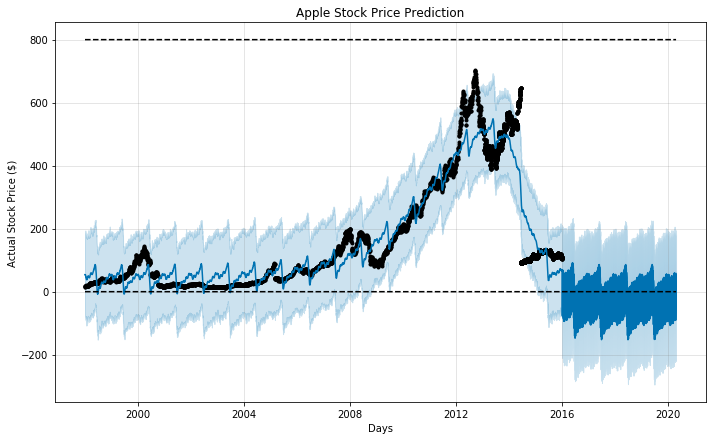

In [338]:
# Predict on the price

forecast = m2.predict(future_no_weekends)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m2.plot(forecast)

plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.show()

- Looking into the predicted line (deep blue), frequent cycles appeared which does not follow much with the real data

#### Look Closely on the Test Data

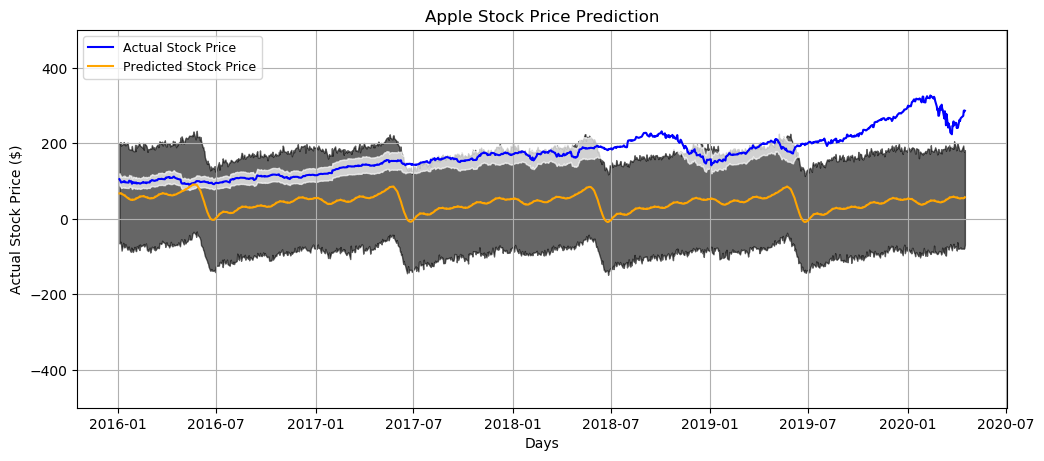

In [339]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_test = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data

plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_test.ds,fc_test.yhat, color = 'orange',label='Predicted Stock Price')

plt.fill_between(fc_test.ds, fc_test.yhat_lower.values, fc_test.yhat_upper.values, 
                 color='k', alpha=.60)
plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.ylim((-500,500))
plt.legend(loc='upper left', fontsize=9)


# mark the 15% price range around the test price data 

plt.fill_between(lower_series.index,.85*test_data_flat,1.15*test_data_flat,
                 color='white', alpha=.70)

plt.show()

- Over cyclic randomness seen on the predicted price (orange) but visibly deviated from the test data

#### Model Performance Evaluation

In [340]:
# performance measures of the model considering saturating points

mse = mean_squared_error(test_data_unique, fc_test.yhat)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_unique, fc_test.yhat)
print('MAE: '+str(mae))

# root mean squared error
rmse = math.sqrt(mean_squared_error(test_data_unique, fc_test.yhat))
print('RMSE: '+str(rmse))

# mean absolute percentage error
mape = np.mean(np.abs(fc_test.yhat - test_data_unique.close.values/np.abs(test_data_unique.close.values)))
print('MAPE: '+str(mape))

# take the average score 

average = np.mean((mse, mae, rmse, mape))

# save the model performances as dataframe

FBProphet_saturating = pd.DataFrame({'model': 'FBProphet_saturating', 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'mape': [mape], 'average_score':[average]})
FBProphet_saturating.head()

MSE: 20332.25140600366
MAE: 129.26575099428092
RMSE: 142.59120381707862
MAPE: 42.73581679664696


,model,mse,mae,rmse,mape,average_score
0,FBProphet_saturating,20332.251406,129.265751,142.591204,42.735817,5161.711044


- Considering saturating point, model performed worse than the base model which is reflected on the average_Score

### Trend Changepoints

FBProphet automatically detects trend chage points in the time-series. However there are options for finer control if the expected trend change points are not captured with automatic control. It will be interesting to see, if FBProphet can capture major economic downturns happened in the past decades which might have impact on the forecasting.

#### Modelling 

In [390]:
# Build the model


m3=Prophet(interval_width=0.95,          # interval_width = confidence interval
          changepoint_range=0.8,         # % of train data to look for change point
                                         # (default value is .8) tuned around .8, which produced better model performance
          changepoint_prior_scale=0.1)  # trend flexibility---(default value is 0.05) 
                                         # higher value== overfit (more flexible) 
                                         # lower value == less flexible ...tuned around by 0.05,..0.1 yielded lower scores 

m3.fit(train_data)


# Create dataframe with the days we want to predict

future = m3.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]

# Predict the price

forecast = m3.predict(future_no_weekends)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

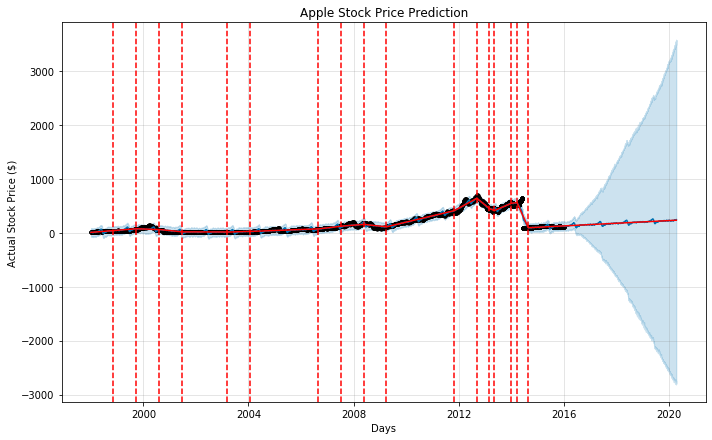

In [391]:
# Predict on the price

forecast = m3.predict(future)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m3.plot(forecast)

# add change points to the plot 

a = add_changepoints_to_plot(fig.gca(), m3, forecast)

plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.show()

- Seeing the changepoints, it is clear that the model is taking into account the trend changes during 2008 recession (middle stripped red lines)
- It is also including high number of trend changes visibly seen after 2012
- FBProphet automatically tracks trend changes and it is doing a good job for this scenario considering 2008 recession and 2014 sharp stock split. Trend change piints can be manually set as well.

#### Look Closely on the Test Data

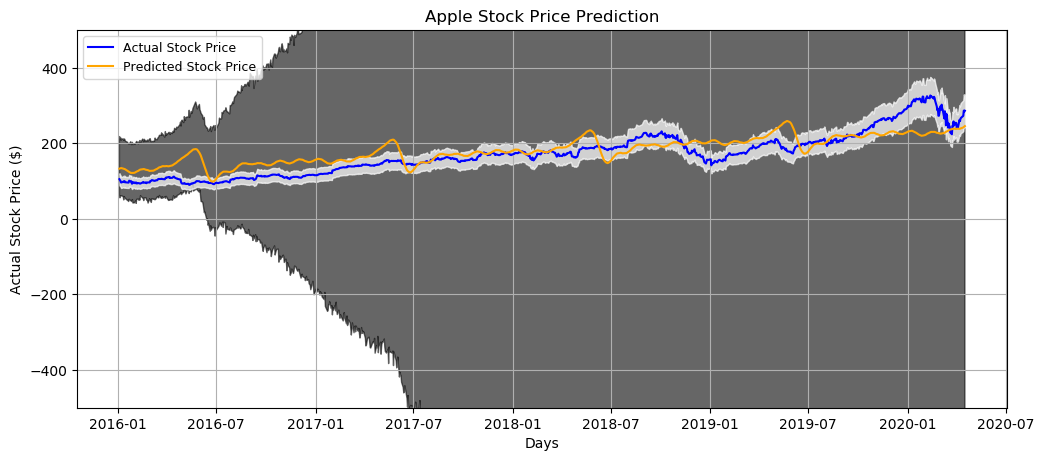

In [392]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_test = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data

plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_test.ds,fc_test.yhat, color = 'orange',label='Predicted Stock Price')

plt.fill_between(fc_test.ds, fc_test.yhat_lower.values, fc_test.yhat_upper.values, 
                 color='k', alpha=.60)
plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.ylim((-500,500))
plt.legend(loc='upper left', fontsize=9)


# mark the 15% price range around the test price data 

plt.fill_between(lower_series.index,.85*test_data_flat,1.15*test_data_flat,
                 color='white', alpha=.70)

plt.show()

- Tuning up with trend change options, alignment between the observed (dark blue) and predicted (orange) data visibly improved a lot and persisted for most of the duration. 

#### Model Performance Evaluation

In [393]:
# performance measures of the model considering trend change

mse = mean_squared_error(test_data_unique, fc_test.yhat)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_unique, fc_test.yhat)
print('MAE: '+str(mae))

# root mean squared error
rmse = math.sqrt(mean_squared_error(test_data_unique, fc_test.yhat))
print('RMSE: '+str(rmse))

# mean absolute percentage error
mape = np.mean(np.abs(fc_test.yhat - test_data_unique.close.values/np.abs(test_data_unique.close.values)))
print('MAPE: '+str(mape))

# take the average score 

average = np.mean((mse, mae, rmse, mape))

# save the model performances as dataframe

FBProphet_trendchange = pd.DataFrame({'model': 'FBProphet_trendchange', 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'mape': [mape], 'average_score':[average]})
FBProphet_trendchange.head()

MSE: 1241.2455402121561
MAE: 28.525021524456665
RMSE: 35.231314767010275
MAPE: 181.9328324217798


,model,mse,mae,rmse,mape,average_score
0,FBProphet_trendchange,1241.24554,28.525022,35.231315,181.932832,371.733677


- Considering trend change points yielded much better result than any pther models and reflected with lowest average_score so far

### Seasonality

By default, FBProphet will fit weekly and yearly seasonality and daily if the data is at least two cylces long. Other seasonalities (monthly, quarterly) can be added manually. From the EDA of Apples stock price it was seen that, there are monthly and yearly stock price trends were seen. This will be interesting to note in the Seasonality analysis.

#### Modelling 

In [560]:
# seasonality

# by default fit weekly and yearly seasonality

m4 = Prophet(interval_width=0.95, daily_seasonality = False)              # no hourly stock data so daily seanonality turned off (default option)

# add seasonality

m4.add_seasonality(name='monthly', period = 30.5, fourier_order = 5)       # Tweeked around fourier_order at 5 (by 2 units around). 
                                                                           # found 5 yielded best result for monthly
m4.add_seasonality(name='quarterly', period = 4*30.5, fourier_order = 7)   # Tweeked around fourier_order at 5 (by 2 units around). 
                                                                           # found 7 yielded best result for quarterly

m4.fit(train_data)

# Create dataframe with the days we want to predict

future = m4.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]



#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

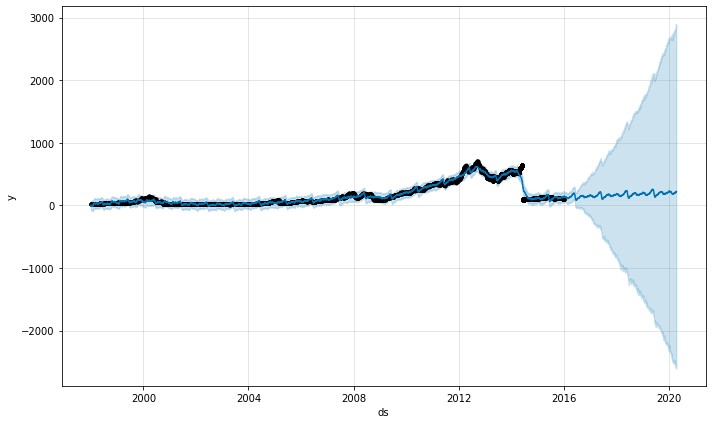

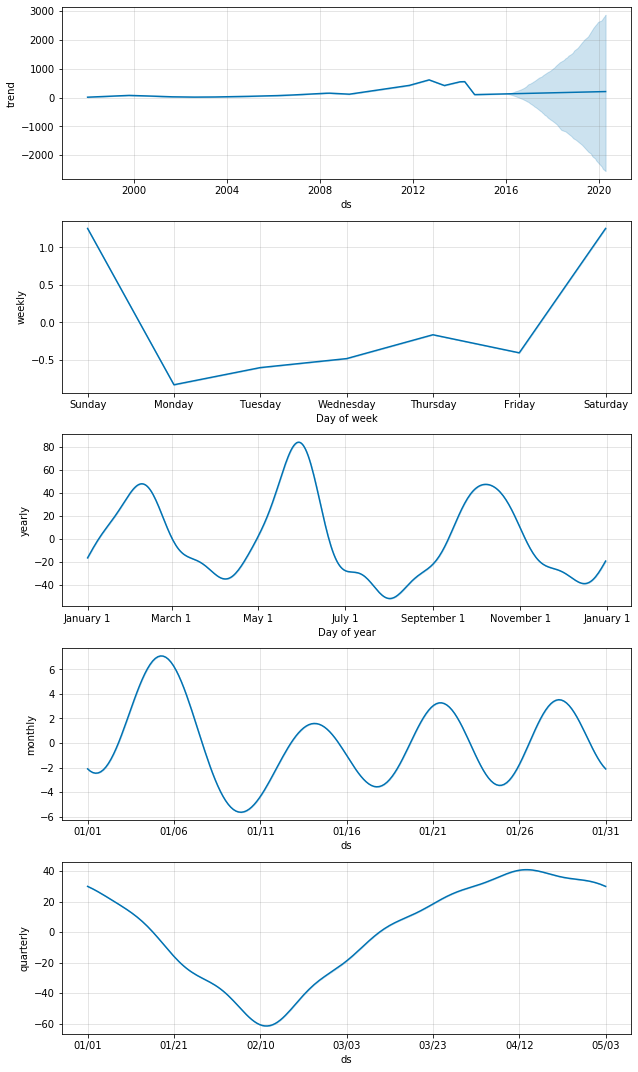

In [561]:
# Predict on the price

forecast = m4.predict(future_no_weekends)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)


fig = m4.plot(forecast)
fig = m4.plot_components(forecast)

plt.grid(True)
plt.show()

- Monthly, weekly, daywise and qarterly break down of the stock price from the modelling provide insights about the trend in the price  

#### Look Closely on the Test Data

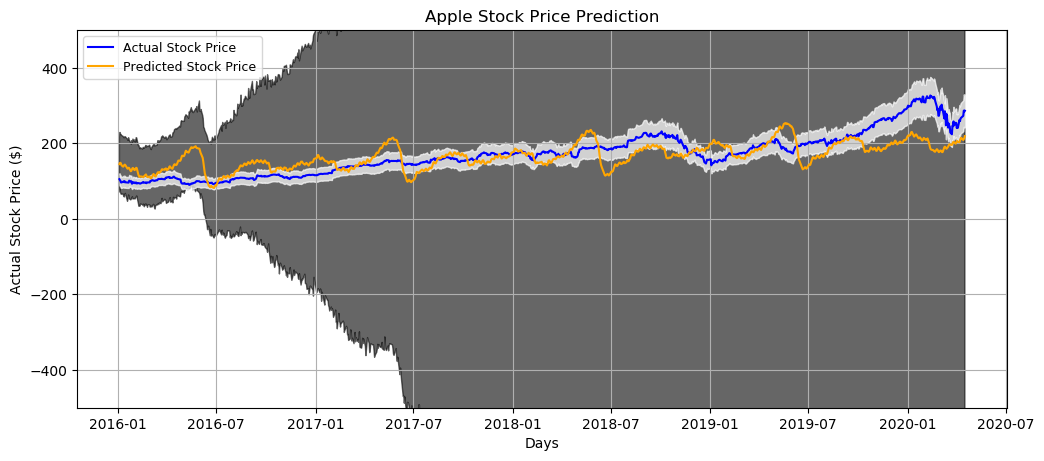

In [554]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_test = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data

plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_test.ds,fc_test.yhat, color = 'orange',label='Predicted Stock Price')

plt.fill_between(fc_test.ds, fc_test.yhat_lower.values, fc_test.yhat_upper.values, 
                 color='k', alpha=.60)
plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.ylim((-500,500))
plt.legend(loc='upper left', fontsize=9)


# mark the 15% price range around the test price data 

plt.fill_between(lower_series.index,.85*test_data_flat,1.15*test_data_flat,
                 color='white', alpha=.70)

plt.show()

- Adding seasonality included more randomness in the prediction and alignment witht he test data

#### Model Performance Evaluation

In [555]:
# performance measures of the model considering seasonalities

mse = mean_squared_error(test_data_unique, fc_test.yhat)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_unique, fc_test.yhat)
print('MAE: '+str(mae))

# root mean squared error
rmse = math.sqrt(mean_squared_error(test_data_unique, fc_test.yhat))
print('RMSE: '+str(rmse))

# mean absolute percentage error
mape = np.mean(np.abs(fc_test.yhat - test_data_unique.close.values/np.abs(test_data_unique.close.values)))
print('MAPE: '+str(mape))

# take the average score 

average = np.mean((mse, mae, rmse, mape))

# save the model performances as dataframe

FBProphet_seasonality = pd.DataFrame({'model': 'FBProphet_seasonality', 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'mape': [mape], 'average_score':[average]})
FBProphet_seasonality.head()

MSE: 1860.2149269590839
MAE: 33.58492010333615
RMSE: 43.13020898348493
MAPE: 166.0948826953538


,model,mse,mae,rmse,mape,average_score
0,FBProphet_seasonality,1860.214927,33.58492,43.130209,166.094883,525.756235


- Adding seasonality in the model improved the prection score by more than 100 margin than the base model

### Holiday Effects

Holidays can have drastic effect on the stock price, trend. For example, stock seen historically slack time during Christmas, beacuse people are busy buying in the shopping market other than the stock. FBProphet can include list of holidays over the train and test duration. The model pays special attention to these points and learns from the changing trend accordingly. 

#### Modelling 

In [556]:
# model with holidays in USA

m5 = Prophet(interval_width=0.95)

m5.add_country_holidays(country_name='US')

train_data_no_weekends = train_data[train_data['ds'].dt.dayofweek < 5]

m5.fit(train_data_no_weekends)

# Create dataframe with the days we want to predict

future = m5.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

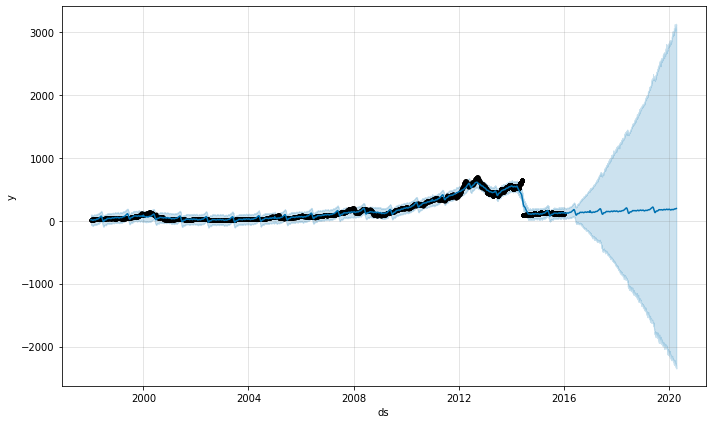

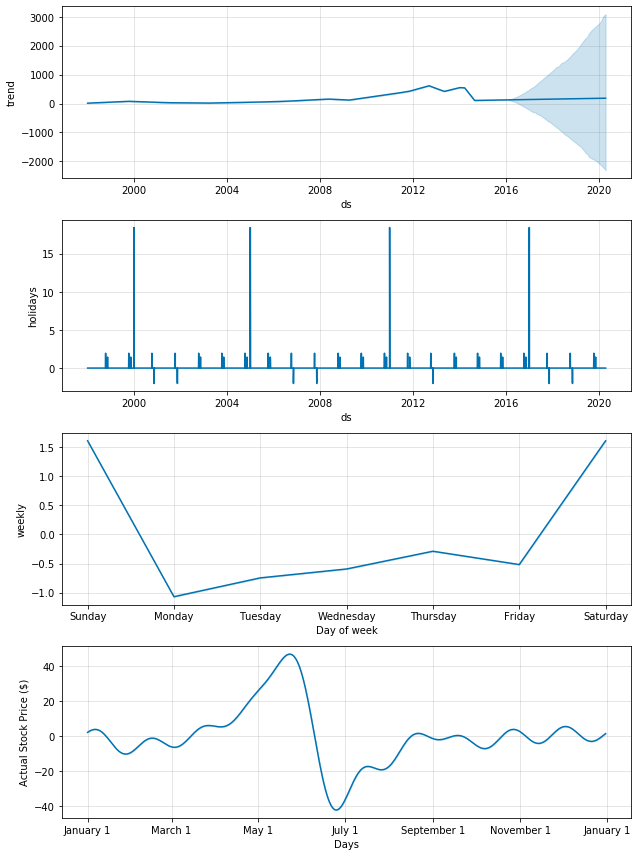

In [562]:
# Predict on the price

forecast = m5.predict(future_no_weekends)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m5.plot(forecast)
fig = m5.plot_components(forecast)


plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.show()

- The monthly trend is what is expected from the EDA. Maximum price in June and minimum in July
- Cyclic spikes seen in the holidays data. That confirms effect of holidays in the price prediction
- Monday seen lowest price and increasedover the weekdays

#### Look Closely on the Test Data

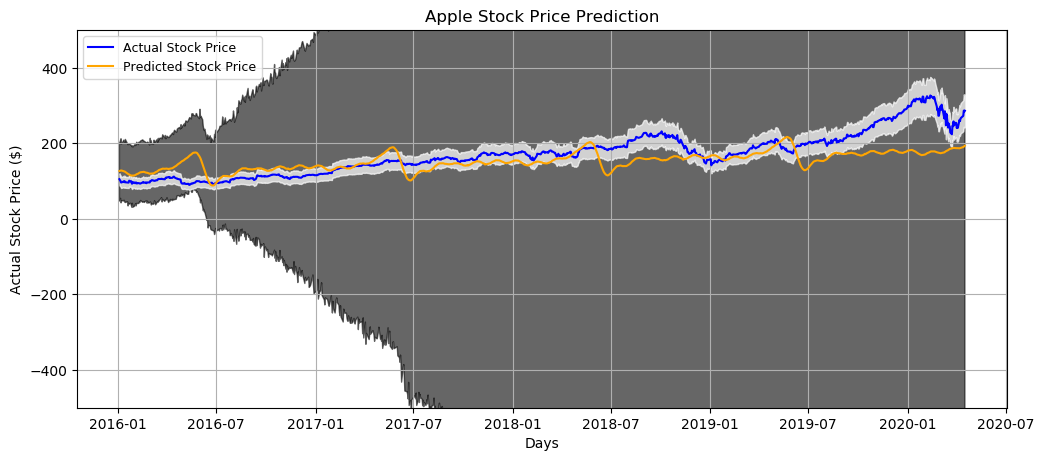

In [558]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_test = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data

plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_test.ds,fc_test.yhat, color = 'orange',label='Predicted Stock Price')

plt.fill_between(fc_test.ds, fc_test.yhat_lower.values, fc_test.yhat_upper.values, 
                 color='k', alpha=.60)
plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.ylim((-500,500))
plt.legend(loc='upper left', fontsize=9)


# mark the 15% price range around the test price data 

plt.fill_between(lower_series.index,.85*test_data_flat,1.15*test_data_flat,
                 color='white', alpha=.70)

plt.show()

- Prediction follows the test data over most of the duration

#### Model Performance Evaluation

In [559]:
# performance measures of the model considering holidays

mse = mean_squared_error(test_data_unique, fc_test.yhat)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_unique, fc_test.yhat)
print('MAE: '+str(mae))

# root mean squared error
rmse = math.sqrt(mean_squared_error(test_data_unique, fc_test.yhat))
print('RMSE: '+str(rmse))

# mean absolute percentage error
mape = np.mean(np.abs(fc_test.yhat - test_data_unique.close.values/np.abs(test_data_unique.close.values)))
print('MAPE: '+str(mape))

# take the average score 

average = np.mean((mse, mae, rmse, mape))

# save the model performances as dataframe

FBProphet_holidays = pd.DataFrame({'model': 'FBProphet_holidays', 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'mape': [mape], 'average_score':[average]})
FBProphet_holidays.head()

MSE: 2262.56418093709
MAE: 35.56426582137554
RMSE: 47.56641862634909
MAPE: 152.50244677962553


,model,mse,mae,rmse,mape,average_score
0,FBProphet_holidays,2262.564181,35.564266,47.566419,152.502447,624.549328


- Adding holidays improved the average_score by a margin of 4 than the base model

### Final Model

Improvements have been seen in terms of score and trend alignment when trend change option was tweeked, seasonaly and holidays added in the models. Here we will come up with a single model with the combinations of these effects.

#### Modelling 

In [535]:
# model with holidays in USA

m6 = Prophet(interval_width=0.95,
            changepoint_prior_scale=0.1)

# adding only monthly seasonality improved the result

m6.add_seasonality(name='monthly', period = 30.5, fourier_order = 3)  # tweeked fourier orders and found 3 yielded better result

# add holidays

m6.add_country_holidays(country_name='US')

m6.fit(train_data)

# Create dataframe with the days we want to predict

future = m6.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

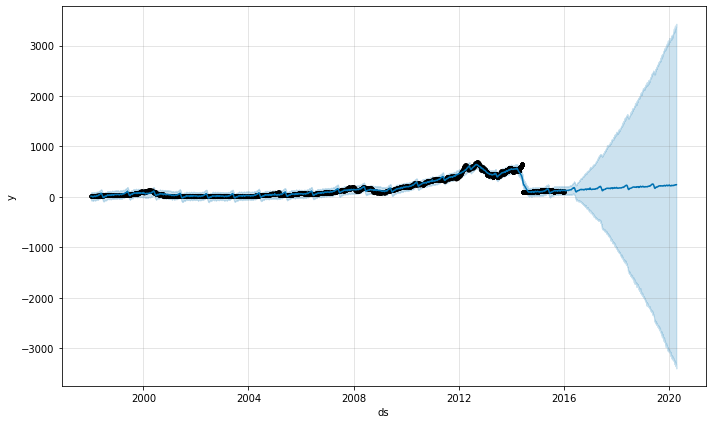

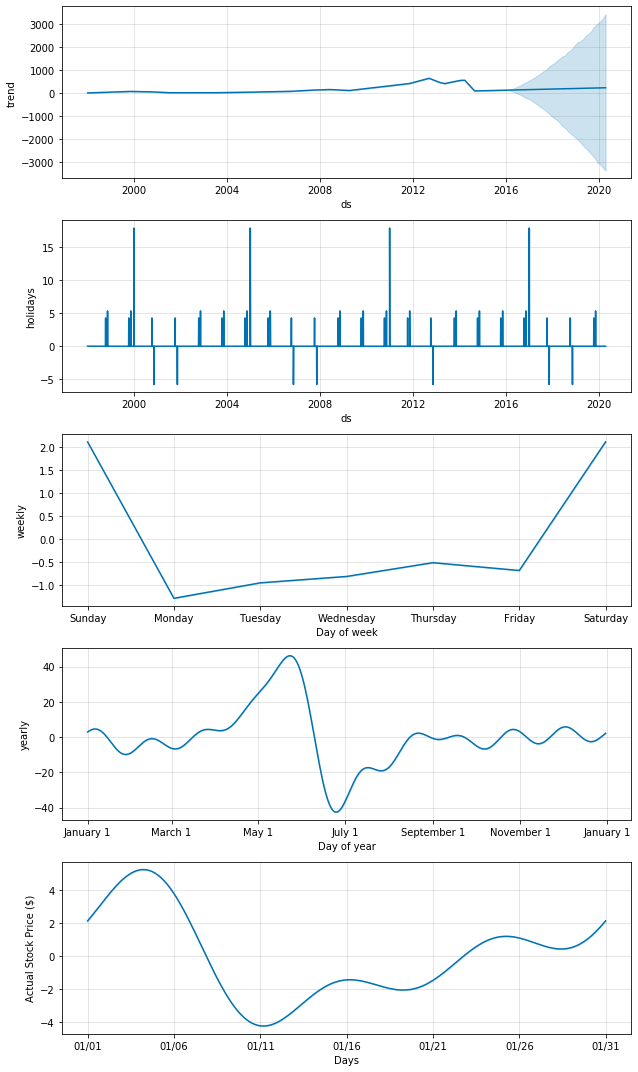

In [564]:
# Predict on the price

forecast = m6.predict(future_no_weekends)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m6.plot(forecast)
fig = m6.plot_components(forecast)


plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.show()

- Similar trend, yearly, weekly, monthly prediction seen in the previous modelling

#### Look Closely on the Test Data

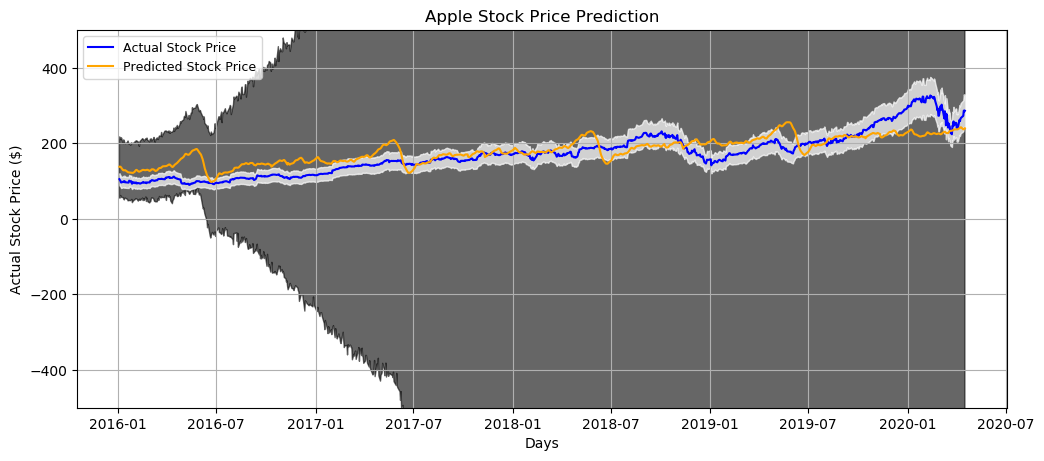

In [537]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_test = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data

plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_test.ds,fc_test.yhat, color = 'orange',label='Predicted Stock Price')

plt.fill_between(fc_test.ds, fc_test.yhat_lower.values, fc_test.yhat_upper.values, 
                 color='k', alpha=.60)
plt.title('Apple Stock Price Prediction')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Actual Stock Price ($)')
plt.ylim((-500,500))
plt.legend(loc='upper left', fontsize=9)


# mark the 15% price range around the test price data 

plt.fill_between(lower_series.index,.85*test_data_flat,1.15*test_data_flat,
                 color='white', alpha=.70)

plt.show()

- Over the test data duration, predicted price showed better alignments with the observed price data

#### Model Performance Evaluation

In [538]:
# performance measures of the final FBProphet model 

mse = mean_squared_error(test_data_unique, fc_test.yhat)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_unique, fc_test.yhat)
print('MAE: '+str(mae))

# root mean squared error
rmse = math.sqrt(mean_squared_error(test_data_unique, fc_test.yhat))
print('RMSE: '+str(rmse))

# mean absolute percentage error
mape = np.mean(np.abs(fc_test.yhat - test_data_unique.close.values/np.abs(test_data_unique.close.values)))
print('MAPE: '+str(mape))

# take the average score 

average = np.mean((mse, mae, rmse, mape))

# save the model performances as dataframe

FBProphet_final = pd.DataFrame({'model': 'FBProphet_final', 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'mape': [mape], 'average_score':[average]})
FBProphet_final.head()

MSE: 1246.4223707273975
MAE: 28.480686707635105
RMSE: 35.30470748678422
MAPE: 180.8248285412584


,model,mse,mae,rmse,mape,average_score
0,FBProphet_final,1246.422371,28.480687,35.304707,180.824829,372.758148


- The final model with FBProphet yielded a score of 372 which is better than ARIMA model but little high compared to the model considering holidays
- This model is considered better than any other model as it includes important factors such as trend chage points, seasonalities (monthly, yearly) and holidays effect

## Model Evaluations

Now score data from all the models are available in terms of MSE, MAE, RMSE, MAPE and average_score. We will dispay and compare results from the variuos modelling.

### Merge Results 

Combine results from all the models stored in the form of dataframe

In [624]:
results = pd.concat([ARIMA, FBProphet_base, 
                     FBProphet_saturating, 
                     FBProphet_trendchange, 
                     FBProphet_seasonality, 
                     FBProphet_holidays, 
                     FBProphet_final], axis=0)

results.head(10)

,model,mse,mae,rmse,mape,average_score
0,ARIMA,2288.394282,36.927865,47.837164,131.096594,626.063976
0,FBProphet_base,2277.779749,35.644298,47.726091,152.030418,628.295139
0,FBProphet_saturating,20332.251406,129.265751,142.591204,42.735817,5161.711044
0,FBProphet_trendchange,1241.245540,28.525022,35.231315,181.932832,371.733677
0,FBProphet_seasonality,1860.214927,33.584920,43.130209,166.094883,525.756235
0,FBProphet_holidays,2262.564181,35.564266,47.566419,152.502447,624.549328
0,FBProphet_final,1246.422371,28.480687,35.304707,180.824829,372.758148


### Bar Plot

Every performance measures will be plotted with respect to the number of models tried here and evaluated which models worked best for each categories.

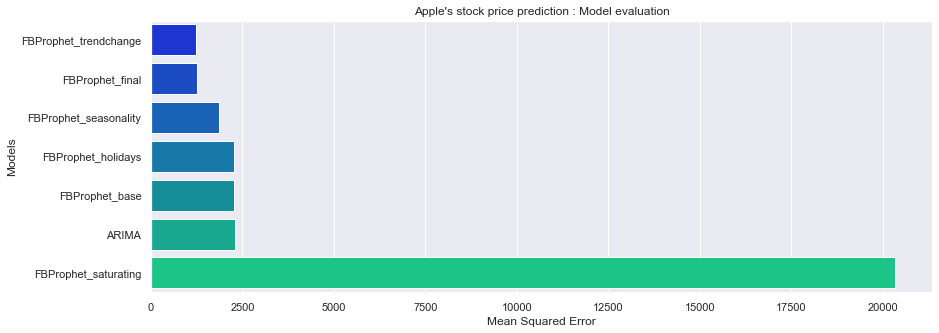

In [618]:
# Mean Squared Error (MSE)

results_mse = results.sort_values(by=['mse'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_mse.mse,
    y=results_mse.model,
    data=results_mse,  
    palette='winter')

ax.set_ylabel("Models")
ax.set_xlabel("Mean Squared Error")
plt.title("Apple's stock price prediction : Model evaluation")
plt.show()


- The final model and with the trend change have the lowest MSE. Trend change wins by a very thin margin. 

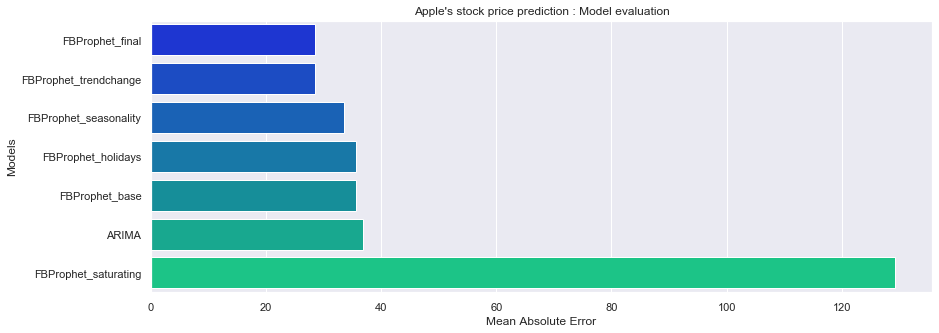

In [619]:
# Mean Absolute Error (MAE)

results_mae = results.sort_values(by=['mae'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_mae.mae,
    y=results_mae.model,
    data=results_mae,  
    palette='winter')

ax.set_ylabel("Models")
ax.set_xlabel("Mean Absolute Error")
plt.title("Apple's stock price prediction : Model evaluation")
plt.show()

- The final model and trend change have the lowest MAE score. Here the final model wins by a very thin margin.

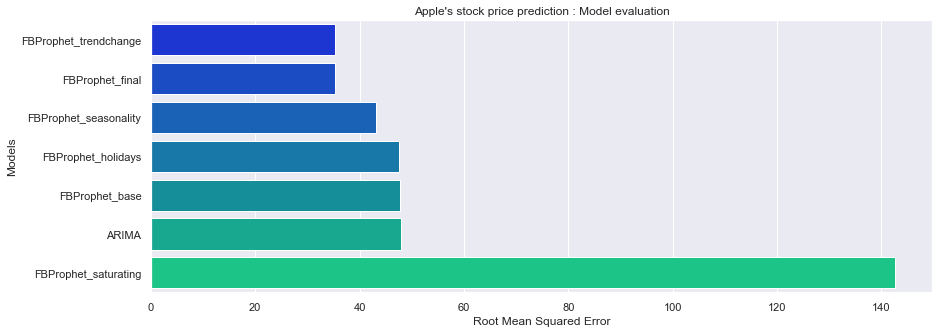

In [620]:
# Root Mean Squared Error (MSE)

results_rmse = results.sort_values(by=['rmse'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_rmse.rmse,
    y=results_rmse.model,
    data=results_rmse,  
    palette='winter')

ax.set_ylabel("Models")
ax.set_xlabel("Root Mean Squared Error")
plt.title("Apple's stock price prediction : Model evaluation")
plt.show()

- The trend change and final model again have the lowest RMSE score with the win of trndchange by a very small margin.

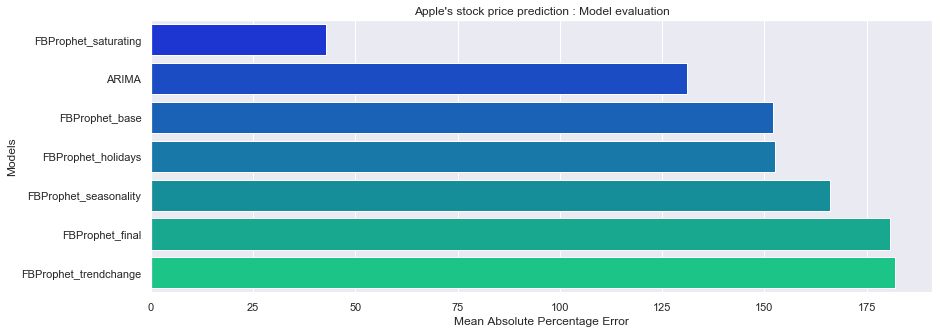

In [621]:
# Mean Absolute Percentage Error (MAE)

results_mape = results.sort_values(by=['mape'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_mape.mape,
    y=results_mape.model,
    data=results_mape,  
    palette='winter')

ax.set_ylabel("Models")
ax.set_xlabel("Mean Absolute Percentage Error")
plt.title("Apple's stock price prediction : Model evaluation")
plt.show()

- Relative low scorer saturating and ARIMA models scored better (less) for MAPE. On the other hand, final and trend change models showed highest levels of MAPE.

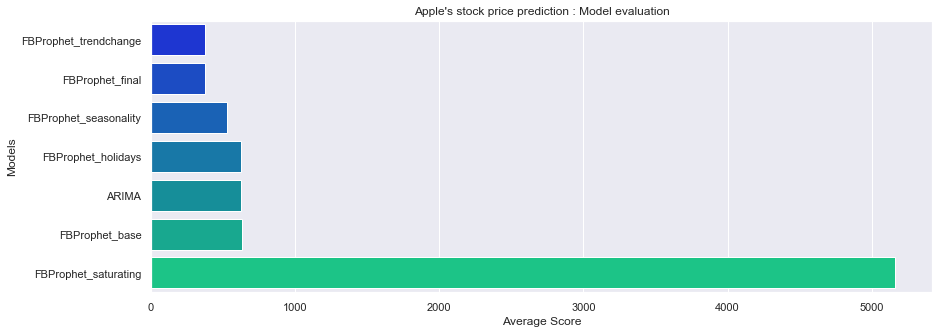

In [623]:
# Average score

results_score = results.sort_values(by=['average_score'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_score.average_score,
    y=results_score.model,
    data=results_score,  
    palette='winter')

ax.set_ylabel("Models")
ax.set_xlabel("Average Score")
plt.title("Apple's stock price prediction : Model evaluation")
plt.show()

- In terms of overall score, trend change and final have the best scores. We would consider final model for forecasting Apple's price, as it incorporates important effects (such as trend, seasonality, holidays) at every points of price data over the forecasting horizon.
